In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
import json
import os
import time

import corner
import dynesty
import isochrones
import matplotlib
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs

import astropy.units as u
from astropy.coordinates import SkyCoord


def get_gaia_data(coord, approx_mag=None, radius=None, **kwargs):
    """Cross match to Gaia and construct a dataset for isochrone fitting

    Args:
        coord (SkyCoord): The coordinates of the source
        approx_mag (float, optional): The magnitude of the source in an
            optical band. If provided, only sources with a Gaia G mag within
            1 mag will be returned.
        radius (Quantity, optional): The angular search radius.

    Raises:
        ValueError: If no match is found or if any of the parameters are not
            finite in the catalog.

    Returns:
        The data dictionary

    """
    # coord = SkyCoord(ra=toi.RA, dec=toi.Dec, unit=(u.hourangle, u.deg))
    if radius is None:
        radius = 20 * u.arcsec
    j = Gaia.cone_search_async(coord, radius)
    r = j.get_results()

    # Only select targets within 1 mag of the target
    if approx_mag is not None:
        r = r[np.abs(r["phot_g_mean_mag"] - approx_mag) < 1]

    if not len(r):
        raise ValueError("no matches found")

    # Select the closest target
    r = r[0]

    # Parallax offset reference: https://arxiv.org/abs/1805.03526
    plx = r["parallax"] + 0.082
    plx_err = np.sqrt(r["parallax_error"] ** 2 + 0.033 ** 2)
    if not (np.isfinite(plx) and np.isfinite(plx_err)):
        raise ValueError("non finite parallax")

    # Convert flux error to magnitude error by linear propagation, this
    # should be ok for bright sources
    factor = 2.5 / np.log(10)
    params = {}
    for band in ["G", "BP", "RP"]:
        mag = float(r["phot_{0}_mean_mag".format(band.lower())])
        err = float(r["phot_{0}_mean_flux_error".format(band.lower())])
        err /= float(r["phot_{0}_mean_flux".format(band.lower())])
        err *= factor
        if not (np.isfinite(mag) and np.isfinite(err)):
            raise ValueError("non finite params")
        params[band] = (mag, err)

    params["parallax"] = (float(plx), float(plx_err))

    # Make sure that the dtypes are all correct
    for k, v in params.items():
        params[k] = np.array(v, dtype=np.float64)
#     if params["parallax"][0] > 0:
#         params["max_distance"] = np.clip(2000 / plx, 100, np.inf)

    params = dict(params, **kwargs)

    return params


def fit_gaia_data(name, gaia_data, clobber=False, bands=None):
    if bands is None:
        bands = ("G", "BP", "RP")
    
    # We will fit for jitter parameters for each magnitude
    jitter_vars = list(bands)

    # Set up an isochrones model using the MIST tracks
    mist = isochrones.get_ichrone("mist", bands=bands)
    mod = isochrones.SingleStarModel(mist, **gaia_data)

    # Return the existing samples if not clobbering
    output_dir = os.path.join("output", __version__, name)
    os.makedirs(output_dir, exist_ok=True)
    fn = os.path.join(output_dir, "star.h5")
    if (not clobber) and os.path.exists(fn):
        mod._samples = pd.read_hdf(fn, "samples")
        mod._derived_samples = pd.read_hdf(fn, "derived_samples")
        return mod

    with open(os.path.join(output_dir, "gaia.json"), "w") as f:
        json.dump(
            dict((k, v.tolist()) for k, v in gaia_data.items()),
            f,
            indent=2,
            sort_keys=True,
        )

    # These functions wrap isochrones so that they can be used with dynesty:
    def prior_transform(u):
        cube = np.copy(u)
        mod.mnest_prior(cube[: mod.n_params], None, None)
        cube[mod.n_params :] = -10 + 20 * cube[mod.n_params :]
        return cube

    def loglike(theta):
        ind0 = mod.n_params
        lp0 = 0.0
        for i, k in enumerate(jitter_vars):
            err = np.sqrt(gaia_data[k][1] ** 2 + np.exp(theta[ind0 + i]))
            lp0 -= 2 * np.log(err)  # This is to fix a bug in isochrones
            mod.kwargs[k] = (gaia_data[k][0], err)
        lp = lp0 + mod.lnpost(theta[: mod.n_params])
        if np.isfinite(lp):
            return np.clip(lp, -1e10, np.inf)
        return -1e10

    # Run nested sampling on this model
    sampler = dynesty.NestedSampler(
        loglike, prior_transform, mod.n_params + len(jitter_vars)
    )
    strt = time.time()
    sampler.run_nested(print_progress=False)
    total_time = (time.time() - strt) / 60.0
    print("Sampling took {0} minutes".format(total_time))

    # Resample the chain to get unit weight samples and update the isochrones
    # model
    results = sampler.results
    samples = dynesty.utils.resample_equal(
        results.samples, np.exp(results.logwt - results.logz[-1])
    )
    df = mod._samples = pd.DataFrame(
        dict(
            zip(
                list(mod.param_names)
                + ["log_jitter_" + k for k in jitter_vars],
                samples.T,
            )
        )
    )
    mod._derived_samples = mod.ic(*[df[c].values for c in mod.param_names])
    mod._derived_samples["parallax"] = 1000.0 / df["distance"]
    mod._derived_samples["distance"] = df["distance"]
    mod._derived_samples["AV"] = df["AV"]

    # Save these results to disk
    mod._samples.to_hdf(fn, "samples")
    mod._derived_samples.to_hdf(fn, "derived_samples")

    # Save the summary to disk
    mod._derived_samples.describe().transpose().to_csv(
        os.path.join(output_dir, "star_summary.csv")
    )

    # Summarize the sampling performance
    summary = dict(
        nlive=int(results.nlive),
        niter=int(results.niter),
        ncall=int(sum(results.ncall)),
        eff=float(results.eff),
        logz=float(results.logz[-1]),
        logzerr=float(results.logzerr[-1]),
        total_time=float(total_time),
    )
    with open(
        os.path.join(output_dir, "star_sampling_summary.json"), "w"
    ) as f:
        json.dump(summary, f, indent=True, sort_keys=True)

    return mod, sampler


def get_info_for_tic(tic):
    r = Catalogs.query_object(
        "TIC {0}".format(tic), radius=20 * u.arcsec, catalog="TIC"
    )
    return r[r["ID"] == "{0}".format(tic)]


def get_gaia_data_for_tic(info, **kwargs):
    coord = SkyCoord(
        ra=float(info["ra"]) * u.deg, dec=float(info["dec"]) * u.deg
    )
    return get_gaia_data(coord, approx_mag=float(info["GAIAmag"]), **kwargs)

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [4]:
info = get_info_for_tic(tic_id)
data = get_gaia_data_for_tic(info)

# Spectroscopic constraints from Bedell
data["Teff"] = np.array([5798, 4])
data["logg"] = np.array([4.48, 0.012])
data["feh"] = np.array([-0.036, 0.003])

print(data)

Query finished.
{'G': array([8.51548767e+00, 2.58685399e-04]), 'BP': array([8.86003304e+00, 1.17458825e-03]), 'RP': array([8.04736233e+00, 1.90724501e-03]), 'parallax': array([17.51601334,  0.06549889]), 'Teff': array([5798,    4]), 'logg': array([4.48 , 0.012]), 'feh': array([-0.036,  0.003])}


In [5]:
mod, sampler = fit_gaia_data("tic/{0}".format(tic_id), data, clobber=True)

Sampling took 2.979224733511607 minutes


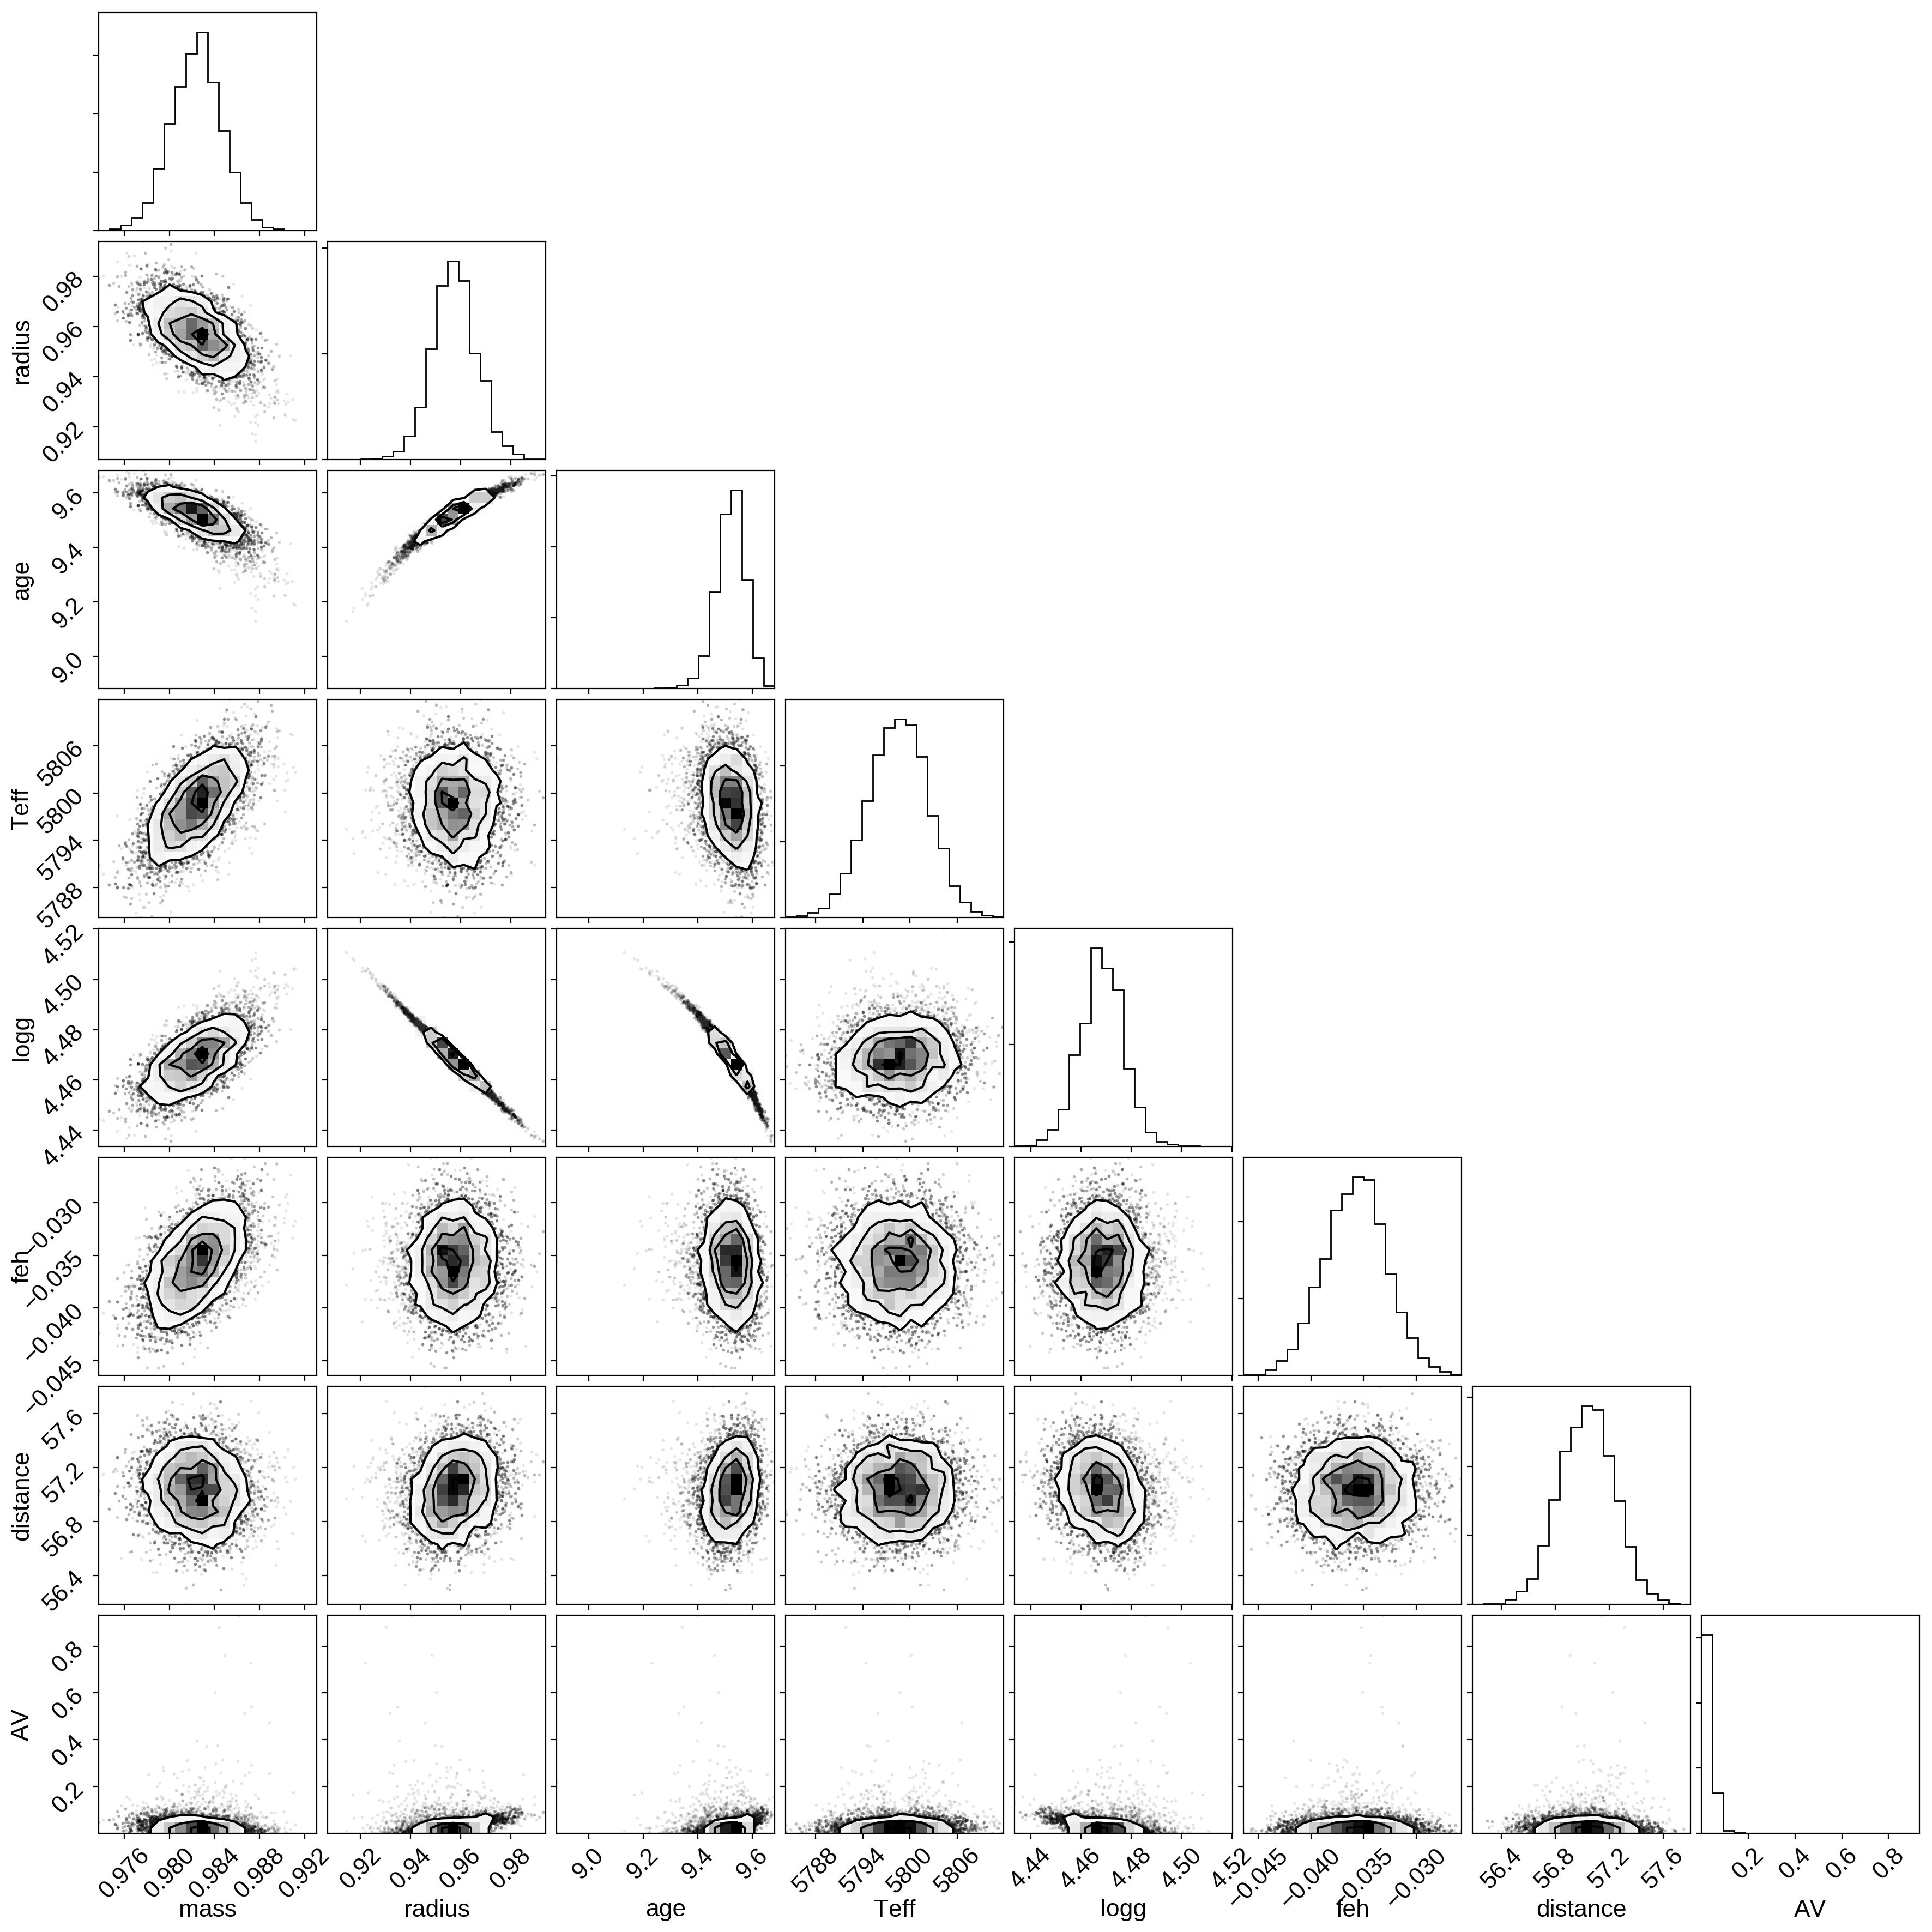

In [12]:
mod.corner_physical();
plt.savefig(base_dir + "star_physical.pdf", bbox_inches="tight");

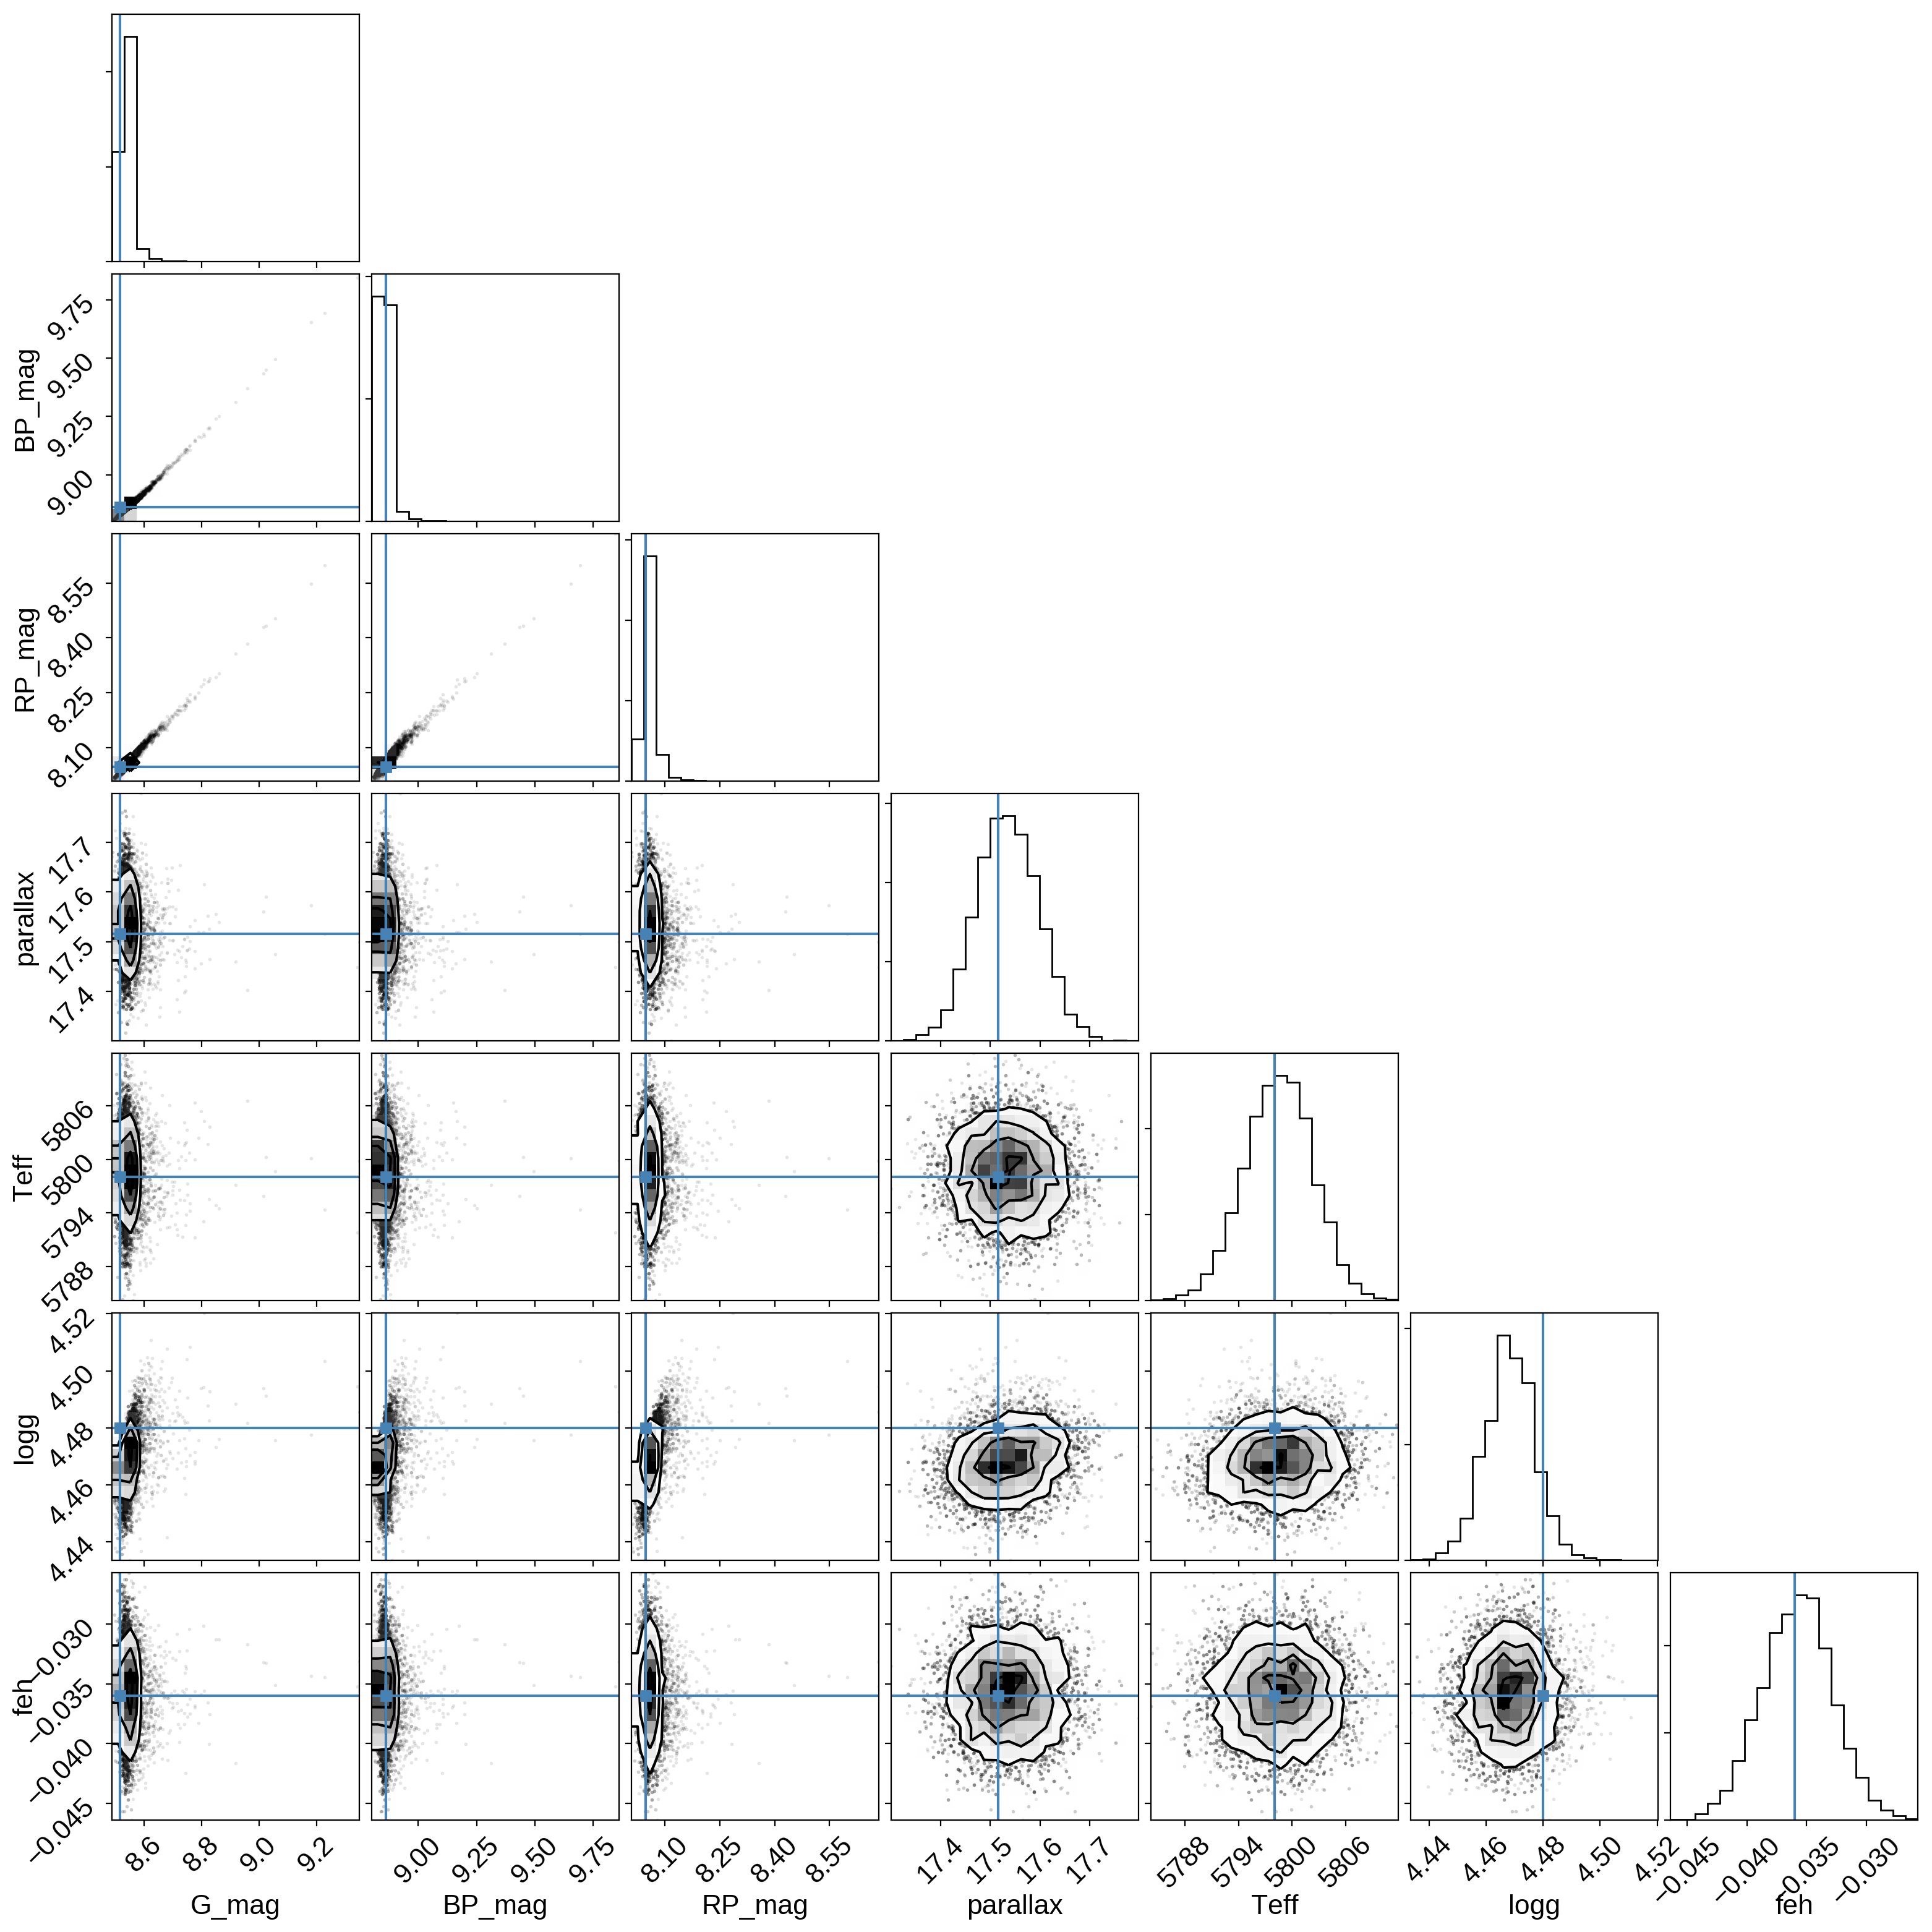

In [11]:
mod.corner_observed()
plt.savefig(base_dir + "star_observed.pdf", bbox_inches="tight");

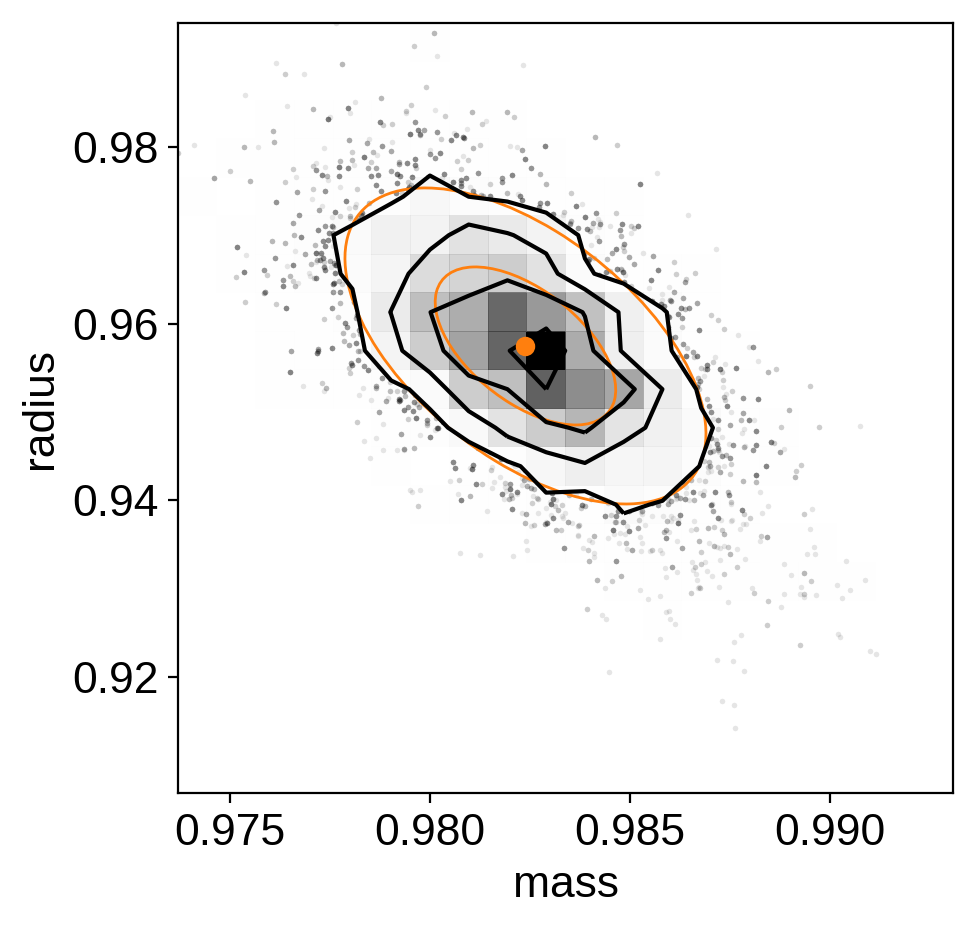

In [14]:
# Extract a Gaussian approximation to the mass and radius
mass = np.array(mod._derived_samples.mass)
radius = np.array(mod._derived_samples.radius)
samples = np.vstack((mass, radius))
mass_radius_mu = np.mean(samples, axis=1)
mass_radius_cov = np.cov(samples)

# Plot this approximation in 2D
fig, ax = plt.subplots(figsize=(5, 5))
corner.hist2d(mass, radius, ax=ax)

# Plot the 1 and 2 "sigma" levels of the Gaussian as ellipses
vals, vecs = np.linalg.eig(mass_radius_cov)
vals = np.sqrt(vals)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
for n in [1, 2]:
    ellipse = matplotlib.patches.Ellipse(
        xy=mass_radius_mu, width=vals[0]*2*n, height=vals[1]*2*n, angle=theta)
    ellipse.set_facecolor("none")
    ellipse.set_edgecolor("C1")
    ax.add_artist(ellipse)

ax.plot(mass_radius_mu[0], mass_radius_mu[1], "o", color="C1")
ax.set_xlabel("mass")
ax.set_ylabel("radius")

fig.savefig(base_dir + "star_mass_radius.pdf", bbox_inches="tight");

In [9]:
with open(base_dir + "mass_radius.json", "w") as f:
    json.dump(dict(mean=mass_radius_mu.tolist(), cov=mass_radius_cov.tolist()), f, sort_keys=True, indent=2)